In [7]:
# install.packages('ROCR')
# install.packages('e1071')

In [48]:
library(dplyr)
library(glmnet)
library(ROCR)
library(e1071)
library(data.table)
library(caret)
library(neuralnet)
library(randomForest)

In [2]:
split_number = 0.5
folds = 5

# Load data
train = fread('train_v2.csv')
transactions = fread('transactions_v2.csv')
setkey(train,"msno")
setkey(transactions,"msno")

# Join Data by "msno"
merged_data = merge(train, transactions, by="msno")

In [3]:
# Get indicies
y = merged_data[, 1]
y = y[[1]]

In [40]:
x <- select(merged_data, -1, -2)
y <- merged_data$is_churn

In [41]:
train.inx <- 1:70000

train.x<- as.matrix(x[train.inx,])
train.y<- as.factor(y[train.inx])

test.x<- as.matrix(x[-train.inx,])
test.y<- as.factor(y[-train.inx])

In [42]:
##(1) logistic regression with L1 regularization (lasso)
glmnet.fit <- cv.glmnet(x = train.x, y = train.y, family = "binomial", type.measure = "auc", nfolds = 5)

png 
  2

[1] 0.8687494

[1] 0.8682533

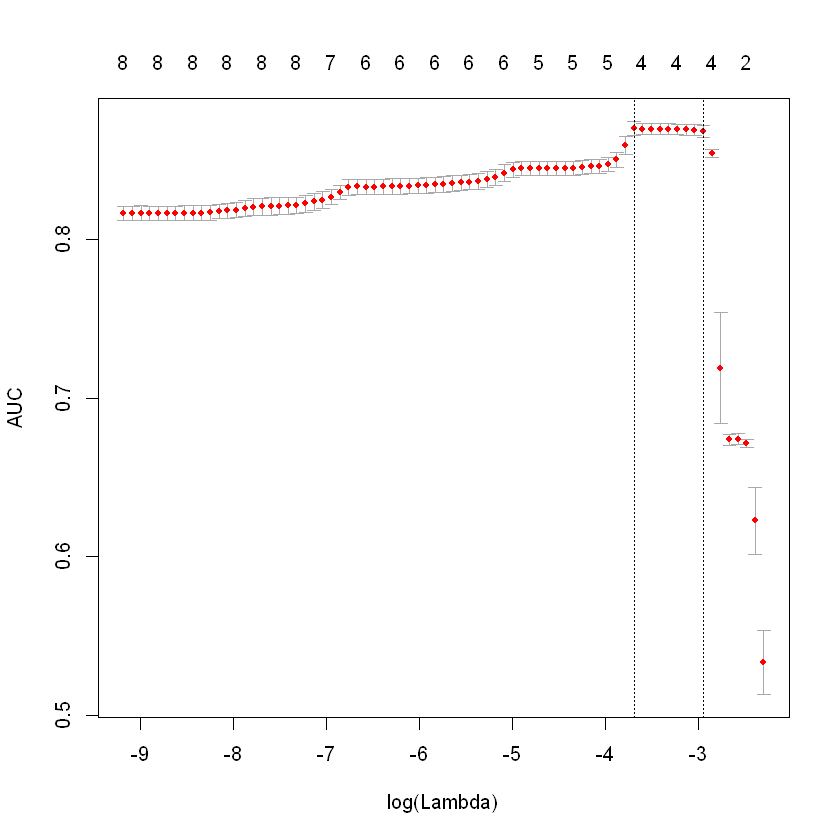

In [43]:
plot(glmnet.fit)
pdf(file="Kaggle5CVplot.pdf")
plot(glmnet.fit)
dev.off()

train.yhat <- predict(glmnet.fit,type = "response", newx = train.x)
train.auc <- performance(prediction(train.yhat[,1], train.y), "auc")@y.values[[1]]

#test on test data
test.yhat <- predict(glmnet.fit,type="response", newx = test.x)
test.auc <- performance(prediction(test.yhat[,1], test.y),"auc")@y.values[[1]]

train.auc
test.auc

png 
  2

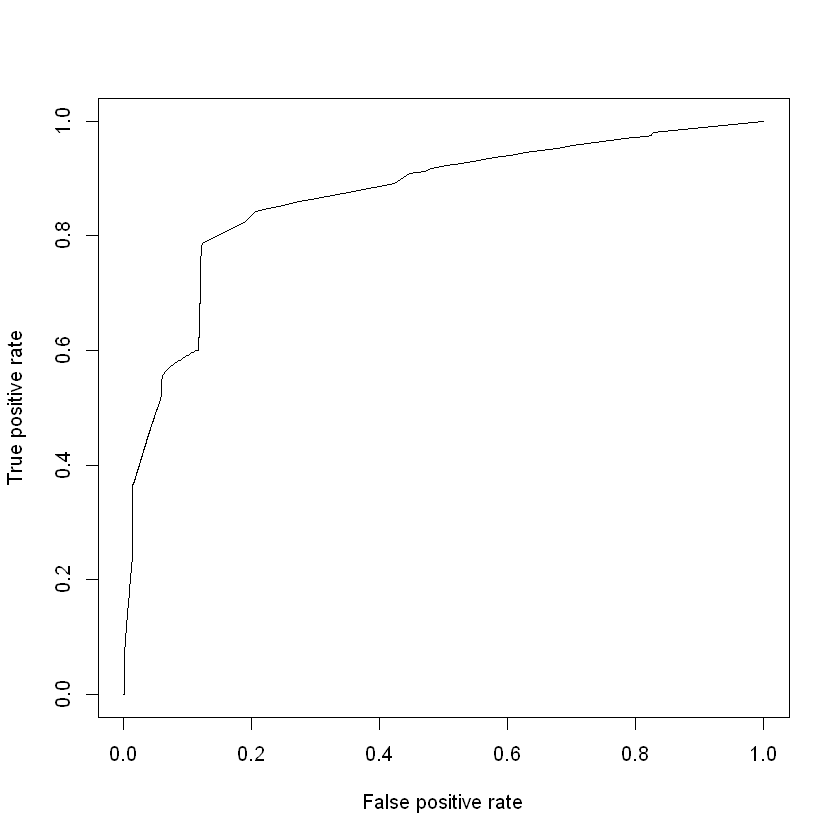

In [44]:
test.pred <- prediction(test.yhat[,1], test.y)
test.perf <- performance(test.pred, "tpr", "fpr")
plot(test.perf)

pdf(file = "KaggleTestROCcurv.pdf")
plot(test.perf)
dev.off()

In [45]:
##(2) SVM
model.SVM <- svm(train.x, train.y) 

# train AUC
train.pred.SVM <- predict(model.SVM, train.x, decision.values = T)
svm.train.auc <- performance(prediction(-attr(train.pred.SVM, "decision.values"),train.y),"auc")@y.values[[1]]

# test AUC
pred.SVM <- predict(model.SVM, test.x, decision.values = T)
svm.test.auc <- performance(prediction(-attr(pred.SVM, "decision.values"),test.y),"auc")@y.values[[1]]

svm.train.auc
svm.test.auc

[1] 0.8850265

[1] 0.8847988

In [56]:
##(3) RF
model.rf <- randomForest(train.x, train.y)

png 
  2

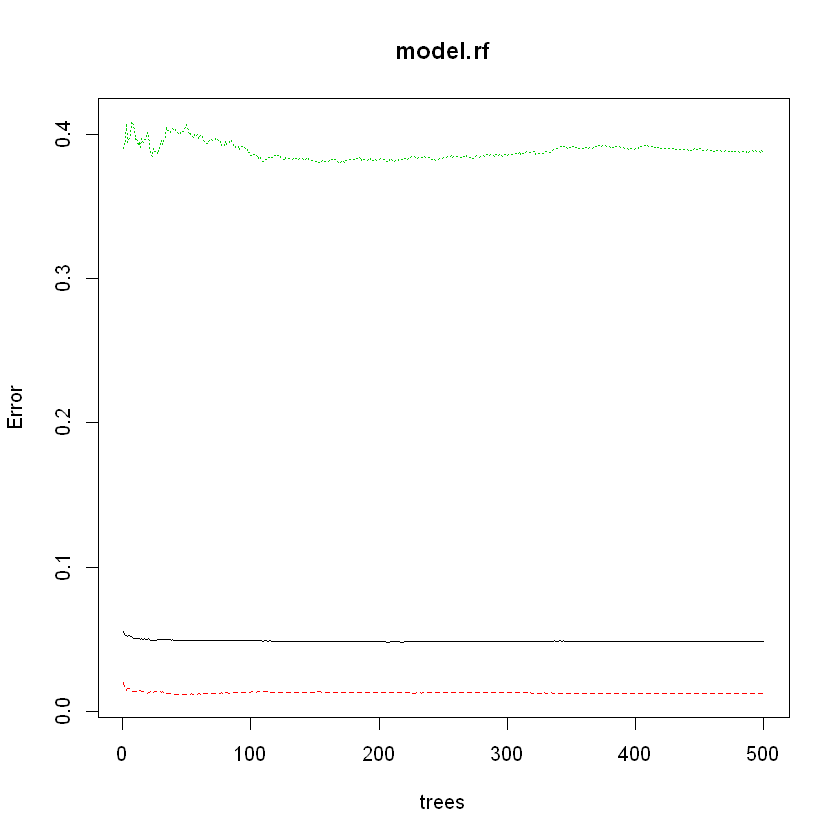

In [58]:
plot(model.rf)
pdf(file="RF.pdf")
plot(model.rf)
dev.off()

In [ ]:
##(3) NN
model.nn <- neuralnet(train.x, train.y, hidden=5, act.fct = "logistic",
                      linear.output = TRUE, stepmax=10^5, threshold = 0.01)

# train AUC
train.pred.nn <- predict(model.nn, train.x, decision.values = T)
nn.train.auc <- performance(prediction(-attr(train.pred.nn, "decision.values"),train.y),"auc")@y.values[[1]]

# test AUC
pred.nn <- predict(model.nn, test.x, decision.values = T)
nn.test.auc <- performance(prediction(-attr(pred.nn, "decision.values"),test.y),"auc")@y.values[[1]]

nn.train.auc
nn.test.auc